In [63]:
import json
with open('/users/jay/desktop/metadata.json') as f:
    metadata_dict = json.load(f)
print(len(metadata_dict))

14964


In [64]:
#import image via cv2
target_size=(224,224)
import cv2
import os
def load_images_from_folder(folder):
    new_dict={}
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,target_size)
            images.append(img)
            new_dict[filename]=metadata_dict[filename]
    return (images,new_dict)


(img_data,img_dict) = load_images_from_folder('/Users/jay/desktop/images')

In [65]:
print(len(img_data))
print(len(img_dict))

14912
14912


In [66]:
#transform the points into bounding box
img_name=list(img_dict)
bound_list=[]
new_list=[]
scalar=224/512
for i in img_name:
    num_points=len(metadata_dict[i]['bounds_x_y'])
    x=[]
    y=[]
    for j in range(num_points):
        x.append(metadata_dict[i]['bounds_x_y'][j]['x'])
        y.append(metadata_dict[i]['bounds_x_y'][j]['y'])
    x_max=max(x)*scalar
    x_min=min(x)*scalar
    y_max=max(y)*scalar
    y_min=min(y)*scalar
    bounds=(x_min,y_min,x_max,y_max)
    bound_list.append(bounds)
    #new=(i,bounds)
    #new_list.append(new)
print(bound_list)


[(102.28548992024453, 93.96179510194432, 121.74732937326867, 117.78819970363512), (97.13373417691106, 88.02993507671309, 126.89908318965855, 123.7653452684935), (85.26661499287083, 89.04831612983982, 138.7333850071292, 122.70167349139368), (86.35489598049462, 80.13795850540205, 137.6451040128149, 131.56487980115645), (99.42731853420699, 93.36717365860318, 124.53985461852854, 118.38282061441089), (101.46113871492479, 90.59857550134429, 122.57169261821838, 121.10608534112838), (95.42976770897744, 88.89568271005659, 128.53741993403696, 122.89958485594954), (101.51585149457011, 90.74831719837047, 122.45128283341613, 121.00167440787877), (99.24860335290845, 95.7913097064035, 124.78426108731715, 115.91326456231583), (89.76475865363409, 90.09355940991236, 134.2678922174179, 121.65643147472656), (97.54640659746488, 87.40549508481777, 126.42074432390493, 124.34449240968766), (94.04790902352568, 83.05250720737318, 129.9520909764743, 128.69747368531748), (92.77387218906176, 94.50419053643576, 131

In [67]:
import numpy as np
bounding_box=np.asarray(bound_list)
print(bounding_box.shape)

(14912, 4)


In [68]:
img_data=np.asarray(img_data)

In [69]:
print(img_data.shape)

(14912, 224, 224, 3)


In [70]:
# plot the bounding box
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bounding(img_data,bounding_box,compare_box=None):
    fig,ax=plt.subplots(1)
    ax.imshow(img_data)
    boxA = patches.Rectangle((bounding_box[0],bounding_box[1]),
                             bounding_box[2]-bounding_box[0],
                             bounding_box[3]-bounding_box[1],
                             linewidth=3,edgecolor='r',
                             facecolor='none')
    ax.add_patch(boxA)    
    if compare_box is not None:
        boxB=patches.Rectangle((compare_box[0],compare_box[1]),
                               compare_box[2]-compare_box[0],
                               compare_box[3]-compare_box[1],
                               linewidth=3,edgecolor='b',
                               facecolor='none')
        ax.add_patch(boxB)
        # calculate Intersection over Union (IoU)
        xA=max(bounding_box[0],compare_box[0])
        yA=max(bounding_box[1],compare_box[1])
        xB=min(bounding_box[2],compare_box[2])
        yB=min(bounding_box[3],compare_box[3])
        interArea=max(0,xB-xA+1)*max(0,yB-yA+1)
        boxAArea = (bounding_box[2] - bounding_box[0] + 1) * (bounding_box[3] - bounding_box[1] + 1)
        boxBArea = (compare_box[2] - compare_box[0] + 1) * (compare_box[3] - compare_box[1] + 1)
        iou =interArea/float(boxAArea+boxBArea-interArea)
        print('intersection of union (IoU) =',iou)
    plt.show()
    
    

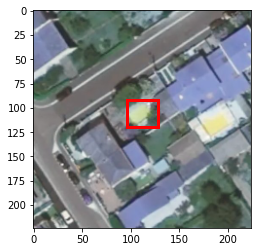

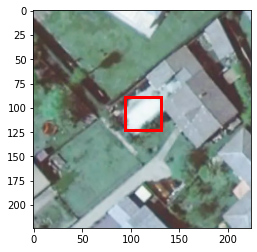

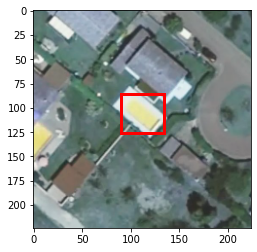

In [73]:
#take a look of 3 random images
for _ in range(3):
 i = np.random.randint(len(img_data))
 plot_bounding(img_data[i],bounding_box[i])

In [74]:
from sklearn.model_selection import train_test_split
#split out the evaluation sets
x_interim, x_eval, y_interim, y_eval = train_test_split(img_data,
                                                        bounding_box,
                                                        test_size=0.2,
                                                        random_state=52)
# split remaining data into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x_interim,
                                               y_interim,test_size=0.4,
                                               random_state=52)
# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print('train samples',x_train.shape[0])
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (7157, 224, 224, 3)
train samples 7157
4772 test samples
2983 eval samples


In [54]:
# somehow the normalization doesn't work properly,so just skip this
""""
# normalize image data
# initialize standard scaler
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

def scale_features(train_features, test_features):
    for image in train_features:
        # for each channel, apply standard scaler's fit_transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.fit_transform(image[:, :, channel])
    for image in test_features:
        # for each channel, apply standard scaler's transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.transform(image[:, :, channel])

# apply scale_features to four sets of features
scale_features(x_interim, x_eval)
scale_features(x_train, x_test)
print(x_train)
""""

SyntaxError: unterminated string literal (detected at line 22) (2966719477.py, line 22)

In [80]:
# use pre-trained model
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
base_model.trainable=False
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])
localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)
model = Model(inputs=[chopped_mobilenet.input], outputs=localization_output)
model.summary()




Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [81]:
model.compile(optimizer='Adam',
              metrics=['accuracy'],
              loss='mse')

In [82]:
history=model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=32,
          epochs=10,
          verbose=1)

Epoch 1/10
224/224 [==============================] - 323s 1s/step - loss: 284.0606 - accuracy: 0.7520 - val_loss: 27.2829 - val_accuracy: 0.8808
Epoch 2/10
224/224 [==============================] - 330s 1s/step - loss: 23.9458 - accuracy: 0.8456 - val_loss: 25.2545 - val_accuracy: 0.8357
Epoch 3/10
224/224 [==============================] - 324s 1s/step - loss: 37.1136 - accuracy: 0.8311 - val_loss: 90.0256 - val_accuracy: 0.8841
Epoch 4/10
224/224 [==============================] - 314s 1s/step - loss: 65.5350 - accuracy: 0.7798 - val_loss: 45.0090 - val_accuracy: 0.8466
Epoch 5/10
224/224 [==============================] - 312s 1s/step - loss: 80.9017 - accuracy: 0.7210 - val_loss: 94.0881 - val_accuracy: 0.8579
Epoch 6/10
224/224 [==============================] - 319s 1s/step - loss: 116.4855 - accuracy: 0.6619 - val_loss: 116.3884 - val_accuracy: 0.6320
Epoch 7/10
224/224 [==============================] - 306s 1s/step - loss: 122.1897 - accuracy: 0.6448 - val_loss: 131.2847 - v

In [84]:
print(history.history)

{'loss': [284.0606384277344, 23.945846557617188, 37.11359786987305, 65.53498840332031, 80.9017333984375, 116.48548126220703, 122.18968963623047, 86.07536315917969, 77.27972412109375, 72.96460723876953], 'accuracy': [0.7519910335540771, 0.8456056714057922, 0.8310744762420654, 0.7797960042953491, 0.72097247838974, 0.6618695259094238, 0.6448232531547546, 0.7008523344993591, 0.7457035183906555, 0.7380187511444092], 'val_loss': [27.282913208007812, 25.25445556640625, 90.02558898925781, 45.0090446472168, 94.08812713623047, 116.38838195800781, 131.2847442626953, 78.3385238647461, 53.5821418762207, 70.83902740478516], 'val_accuracy': [0.8807627558708191, 0.8357083201408386, 0.8841156959533691, 0.8466051816940308, 0.8579211831092834, 0.632020115852356, 0.5502933859825134, 0.8631600737571716, 0.8491198420524597, 0.8430427312850952]}


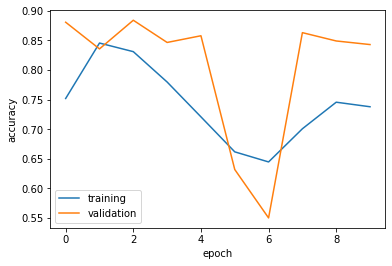

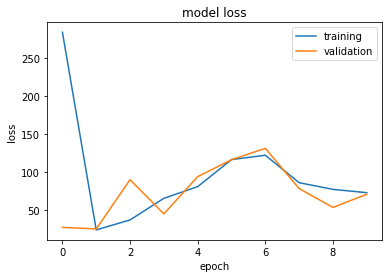

In [86]:
def plot_training_history(history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

plot_training_history(history,model)

1/1 [==============================] - 1s 735ms/step
intersection of union (IoU) = 0.5877960648547265


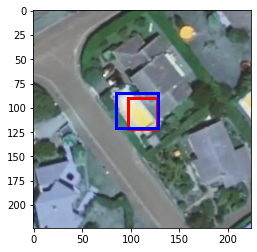

1/1 [==============================] - 0s 59ms/step
intersection of union (IoU) = 0.4467500195057294


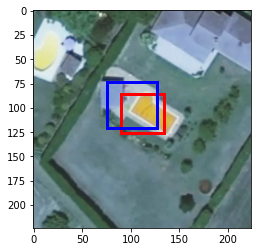

1/1 [==============================] - 0s 70ms/step
intersection of union (IoU) = 0.39174699539165353


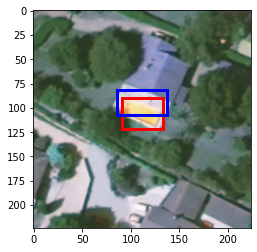

1/1 [==============================] - 0s 58ms/step
intersection of union (IoU) = 0.23267707252679018


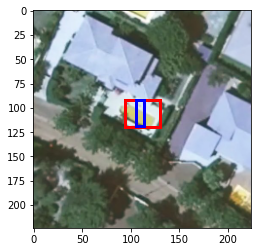

1/1 [==============================] - 0s 65ms/step
intersection of union (IoU) = 0.7548999806133587


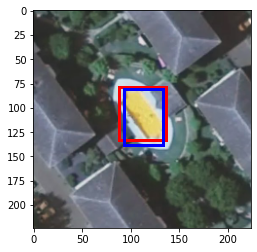

1/1 [==============================] - 0s 69ms/step
intersection of union (IoU) = 0.3863758361018776


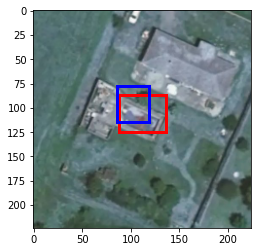

1/1 [==============================] - 0s 58ms/step
intersection of union (IoU) = 0.5656171797944998


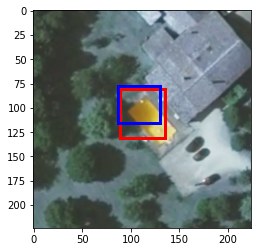

1/1 [==============================] - 0s 62ms/step
intersection of union (IoU) = 0.5522971704653022


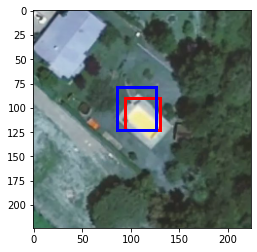

1/1 [==============================] - 0s 64ms/step
intersection of union (IoU) = 0.1604041515818184


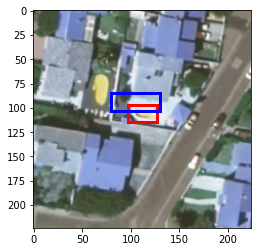

In [87]:
# take a look of 9 random images in the evaluation set
# red box is the real box, while blue box is the predicted box
for _ in range(9):
 i = np.random.randint(len(x_eval))
 img=x_eval[i]
 img_input=img[None]
 true_bounding=y_eval[i]
 pred=model.predict(img_input)
 pred=np.asarray(pred)
 plot_bounding(img,true_bounding,pred[0])

In [88]:
eval_score=model.evaluate(x_eval,y_eval)

94/94 [==============================] - 83s 879ms/step - loss: 73.7776 - accuracy: 0.8351
